In [1]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score
from scipy.stats import zscore
import pandas as pd
import pickle
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from json import JSONDecoder, JSONDecodeError  # for reading the JSON data files
import re  # for regular expressions
import os  # for os related operations

import lightgbm as lgb
from tqdm import tqdm_notebook as tqdm

from sklearn import svm
from sklearn.metrics import confusion_matrix

from sklearn.metrics import log_loss
from collections import Counter

from datetime import datetime
from sklearn.model_selection import train_test_split
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 199)


# print(os.getcwd())

In [2]:
len_cluster = 9
feature_cols = ['CPU1TempTemperatureReading-TemperatureReading', 'CPU2TempTemperatureReading-TemperatureReading', 'CUPSSystemUsage-CPUUsage', 'CUPSSystemUsage-IOUsage', 'CUPSSystemUsage-MemoryUsage', 'CUPSSystemUsage-SystemUsage', 'DIMMSocketA1TemperatureReading-TemperatureReading', 'DIMMSocketA2TemperatureReading-TemperatureReading', 'DIMMSocketA3TemperatureReading-TemperatureReading', 'DIMMSocketA4TemperatureReading-TemperatureReading', 'DIMMSocketA5TemperatureReading-TemperatureReading', 'DIMMSocketA6TemperatureReading-TemperatureReading', 'Fan1RPMReading-RPMReading', 'Fan2RPMReading-RPMReading', 'Fan3RPMReading-RPMReading', 'Fan4RPMReading-RPMReading', 'Fan5RPMReading-RPMReading', 'Fan6RPMReading-RPMReading', 'PowerMetricsTotalStoragePower-SystemPowerConsumption', 'PowerMetricsTotalStoragePower-TotalCPUPower', 'PowerMetricsTotalStoragePower-TotalMemoryPower', 'ThermalTotalPSUHeatDissipation-PowerToCoolRatio', 'ThermalTotalPSUHeatDissipation-SysAirflowPerSysInputPower']

centers_df = pd.read_csv("data/data_cluster.csv")

centers_df = centers_df[feature_cols]

## MinMax norm
for c in feature_cols:
    centers_df[c] = MinMaxScaler().fit_transform(centers_df[c].values.reshape((centers_df[c].shape[0], -1)))

## num of clusters   
len_cluster = centers_df.shape[0]

## convert pandas to list
center_list = [centers_df.iloc[i].values for i in range(len_cluster)]




In [3]:
def find_cluster_(point):
    return np.argmin([np.linalg.norm(point - center_list[i]) for i in range(len_cluster)])

def find_cluster_matrix_(matrix):
    return np.array(list(map(find_cluster, matrix)))


def find_cluster(point):
    distance_list = np.array([np.linalg.norm(point - center_list[i]) for i in range(len_cluster)])
    _sum = np.sum(distance_list)
    distance_probs = 1 / (distance_list+1)
    distance_probs = distance_probs / np.sum(distance_probs)
    return distance_probs

def find_cluster_matrix(matrix):
    return np.array(list(map(find_cluster, matrix)))


# read pickle
with open('output/X_train.pkl', 'rb') as handle:
    X_train = pickle.load(handle)

with open('output/X_test.pkl', 'rb') as handle:
    X_test = pickle.load(handle)
    

with open('output/explainer.pkl', 'rb') as handle:
    explainer = pickle.load(handle)

with open('output/shap_values.pkl', 'rb') as handle:
    shap_values = pickle.load(handle)
    
    


In [4]:
shap_values_np = np.array(shap_values)
shap.initjs()

In [5]:
shap_values_np.shape

(9, 500, 23)

# Show feature importance for each feature of each class 

In [6]:
shap_importance = pd.DataFrame({"feature_name": feature_cols})

for i in range(len_cluster):
    shap_class_i = pd.DataFrame({"feature_name": feature_cols, f"cluster_{i}": np.abs(shap_values[i]).sum(axis=0)})
    shap_importance = pd.merge(shap_importance, shap_class_i, on="feature_name", how="inner")
shap_importance

feature_name  cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  cluster_6  cluster_7  cluster_8
0               CPU1TempTemperatureReading-TemperatureReading   2.292604   1.422808   1.275054   1.283055   0.378127   0.431771   2.299185   1.740986   1.570314
1               CPU2TempTemperatureReading-TemperatureReading   2.650711   1.663362   1.511105   1.617837   0.958918   1.039188   2.169577   1.716976   1.557126
2                                    CUPSSystemUsage-CPUUsage   1.847751   1.067120   0.999225   1.125100   2.127130   2.484302   4.139422   2.294993   1.412395
3                                     CUPSSystemUsage-IOUsage   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000
4                                 CUPSSystemUsage-MemoryUsage   1.800290   1.030753   0.984860   1.081975   2.083822   2.442346   4.094510   2.302085   1.416176
5                                 CUPSSystemUsage-SystemUsage   1.828570   1.046901   0.989315   1.124584   2.136912   2.483858   4.133117   2.325183   1.434228
6           DIMMSocketA1TemperatureReading-TemperatureReading   1.334908   2.397398   1.206978   0.429135   0.212859   0.197147   0.361195   0.283480   0.310280
7           DIMMSocketA2TemperatureReading-TemperatureReading   3.433626   1.716523   1.366323   1.354656   1.958008   2.308949   3.179086   2.230806   2.120831
8           DIMMSocketA3TemperatureReading-TemperatureReading   1.331376   2.398081   1.202432   0.429859   0.210184   0.206667   0.363825   0.288807   0.311112
9           DIMMSocketA4TemperatureReading-TemperatureReading   4.702882   1.556269   0.914884   0.900528   1.464266   2.339984   2.772464   2.190288   2.130892
10          DIMMSocketA5TemperatureReading-TemperatureReading   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000
11          DIMMSocketA6TemperatureReading-TemperatureReading   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000
12                                  Fan1RPMReading-RPMReading   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000
13                                  Fan2RPMReading-RPMReading   1.219803   0.772269   0.688718   1.244516   1.468999   0.416015   0.731108   0.468283   0.285073
14                                  Fan3RPMReading-RPMReading   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000
15                                  Fan4RPMReading-RPMReading   2.178591   0.694927   0.162139   1.141048   1.485072   2.394428   3.518859   0.382780   0.119028
16                                  Fan5RPMReading-RPMReading   1.162130   0.741959   0.727418   1.136510   1.424784   2.620036   1.991933   0.388712   0.207180
17                                  Fan6RPMReading-RPMReading   0.688682   0.380036   0.359846   0.792602   1.024921   3.022975   1.951009   0.794153   0.454750
18       PowerMetricsTotalStoragePower-SystemPowerConsumption   3.203080   2.293839   1.189687   0.956472   0.864845   1.021404   2.280951   1.570154   2.401276
19                PowerMetricsTotalStoragePower-TotalCPUPower   1.976978   1.270187   0.720433   0.594981   0.564861   0.714024   1.629787   0.976456   2.023036
20             PowerMetricsTotalStoragePower-TotalMemoryPower   1.123646   1.734070   0.611068   0.363754   0.410807   0.492997   0.968866   0.563934   1.478555
21            ThermalTotalPSUHeatDissipation-PowerToCoolRatio   2.517681   1.393502   0.639116   0.675758   1.166771   1.594962   2.345103   1.647984   0.806082
22  ThermalTotalPSUHeatDissipation-SysAirflowPerSysInputPower   2.852545   1.645328   0.387254   0.348045   0.611558   1.156074   2.163681   1.505262   0.525677

In [7]:
import plotly.graph_objects as go

x = list(range(len_cluster))

fig = go.Figure()
for i in range(shap_importance.shape[0]):
    fig.add_trace(go.Bar(x=x, y=shap_importance.iloc[i, 1:], name=shap_importance.iloc[i, 0]))


fig.update_layout(barmode='relative', title_text='Feature importance for each cluster, colored by feature names',   
        yaxis=dict(
        title='importance value',
    ),   xaxis=dict(
        title='Cluster',
    ))
fig.show()

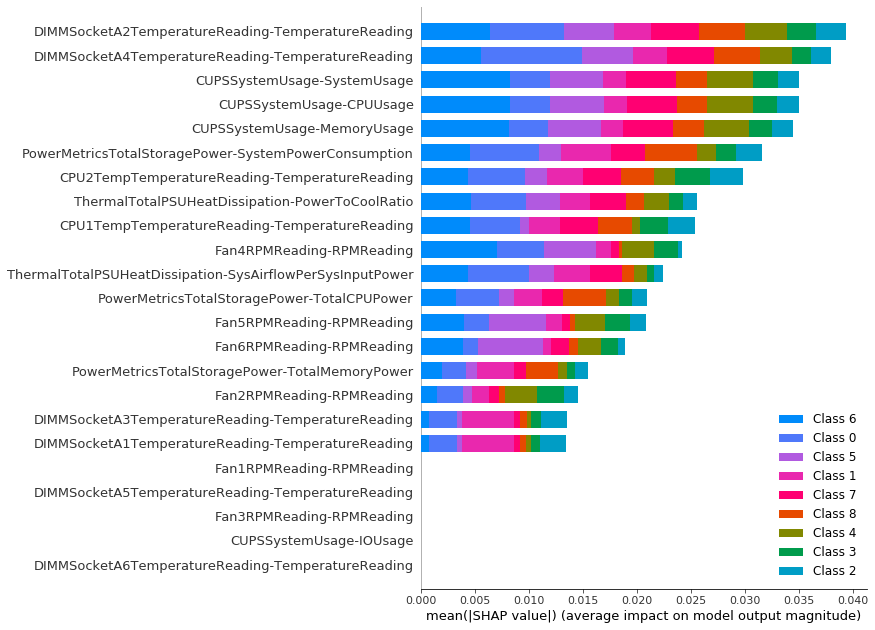

In [8]:
## Feature importance of each feature, colored by cluster

shap.summary_plot(shap_values, X_test, max_display =  len(feature_cols), show=False, plot_type = "bar",feature_names=feature_cols)

cluster 0


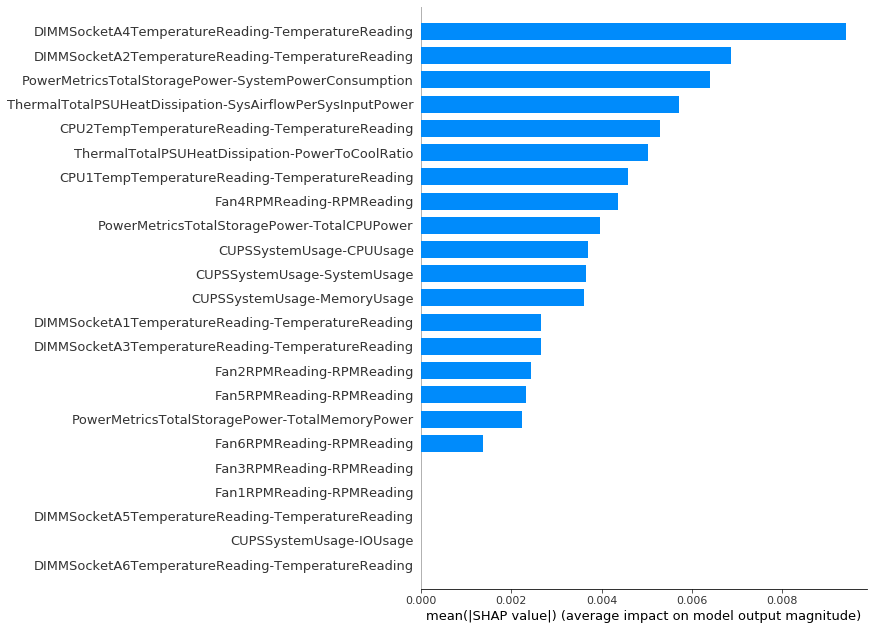



cluster 1


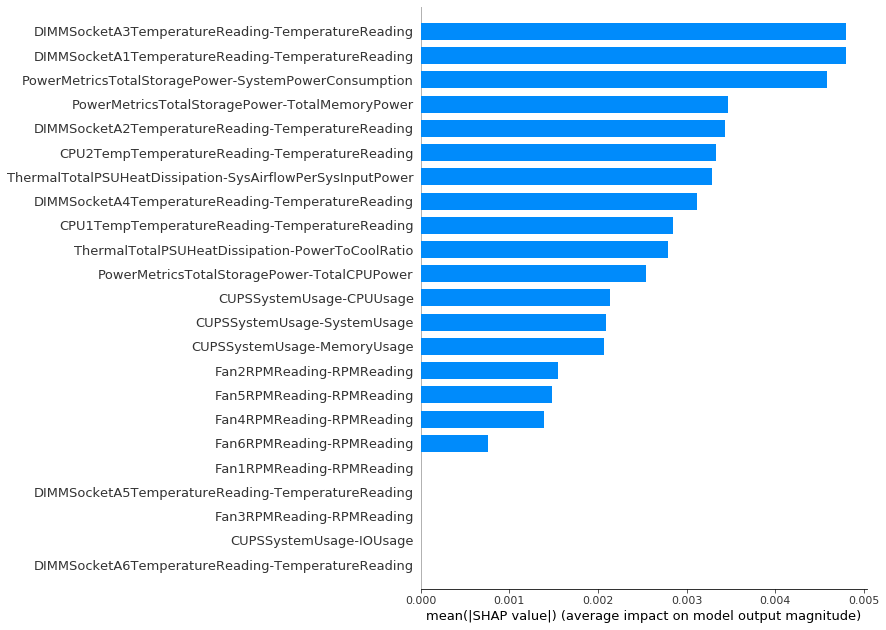



cluster 2


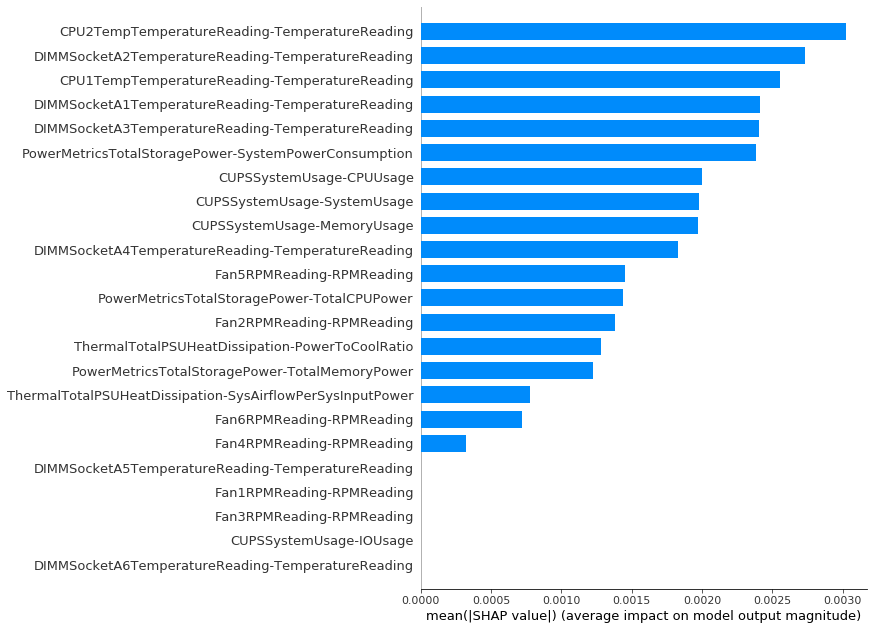



cluster 3


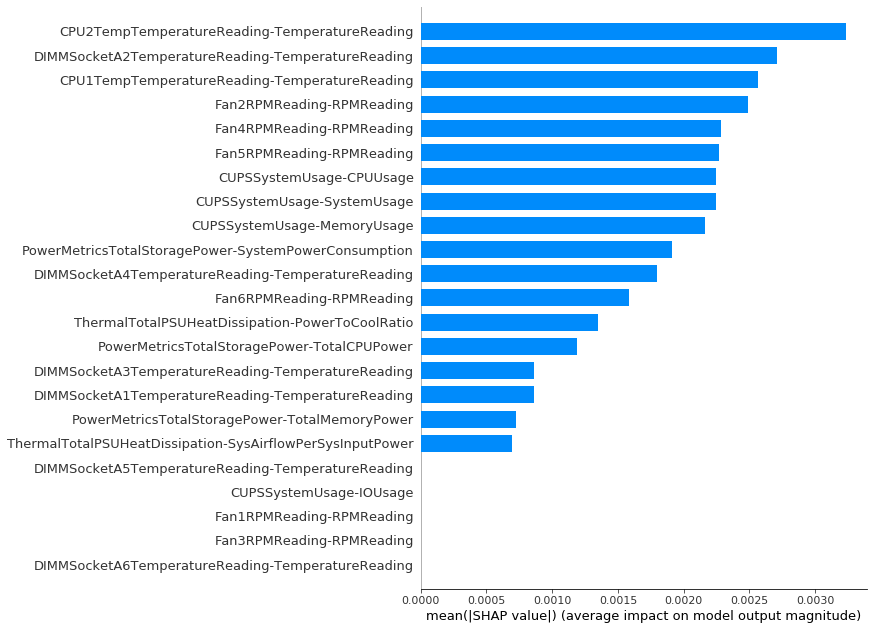



cluster 4


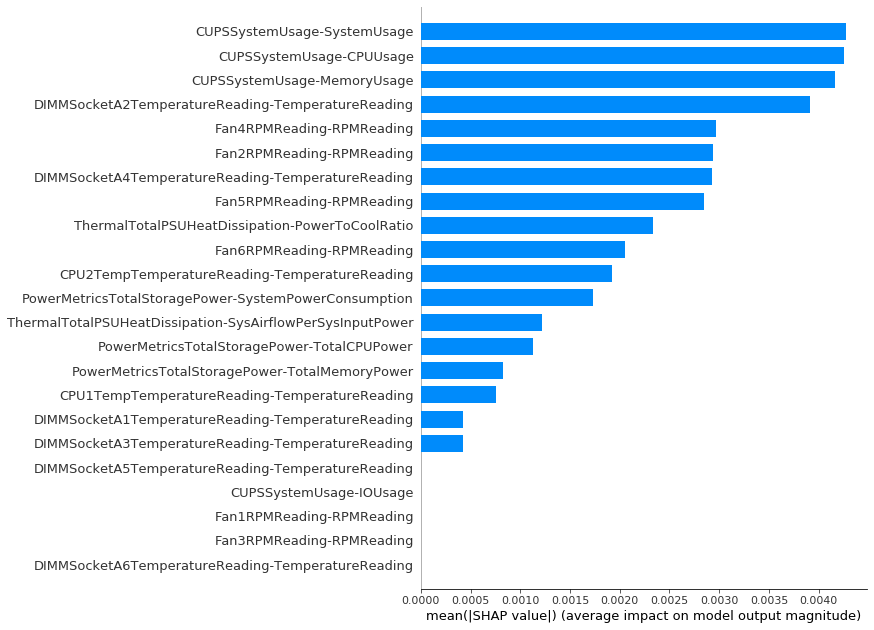



cluster 5


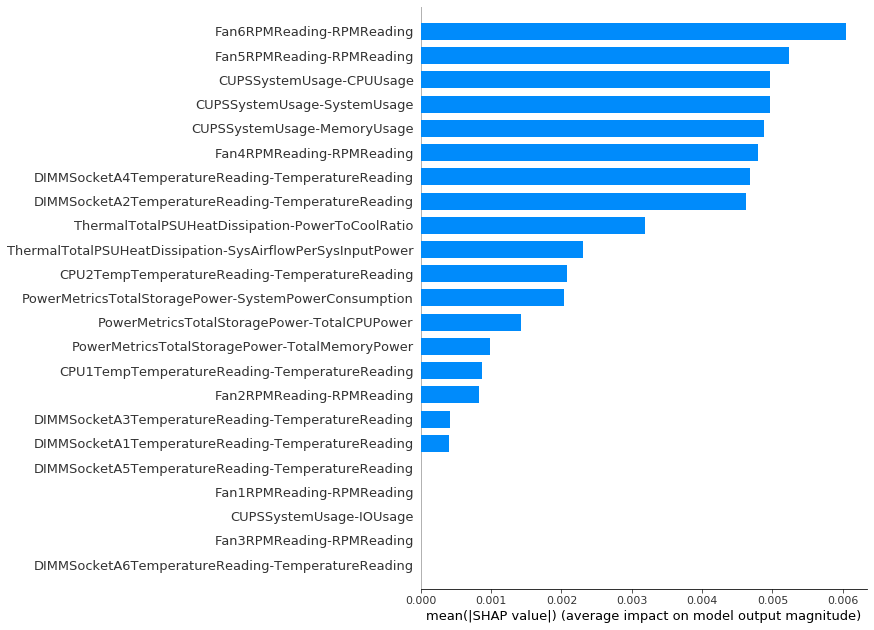



cluster 6


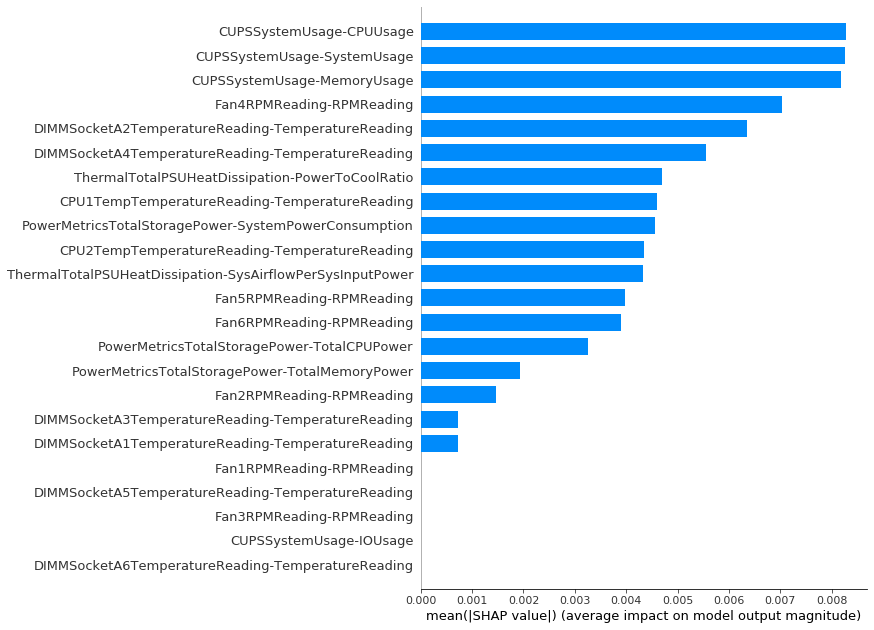



cluster 7


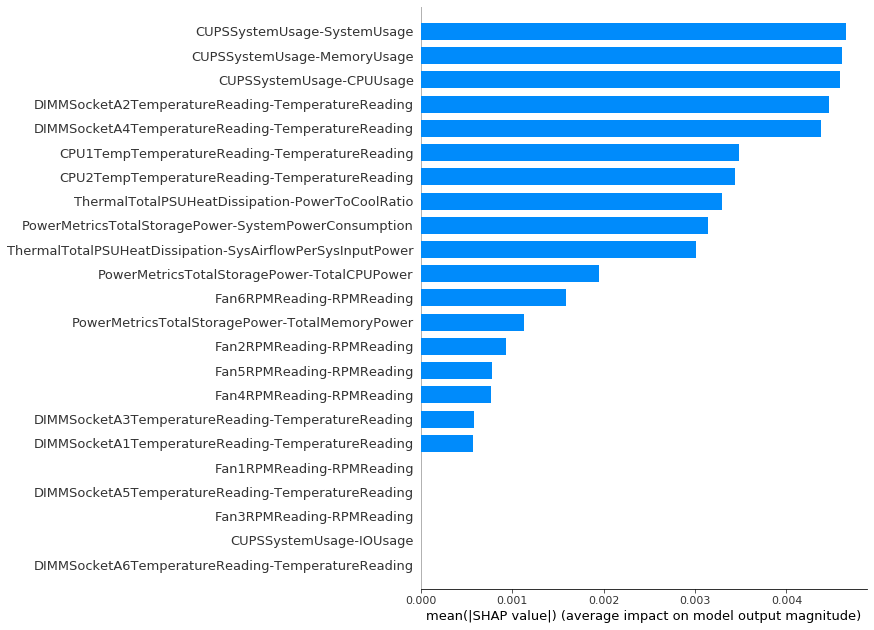



cluster 8


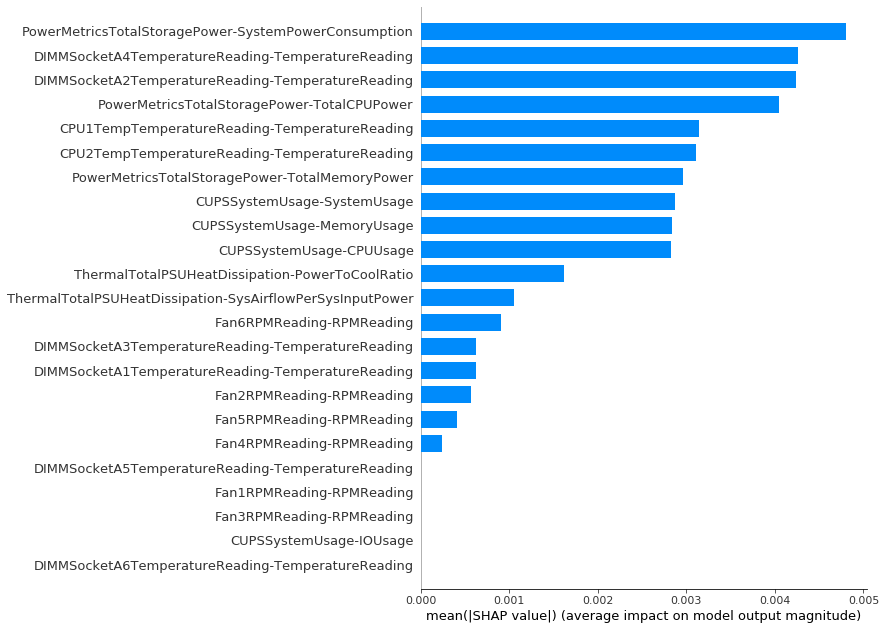

In [9]:
## Show top feature importances of each class
for i in range(len_cluster):
    f = shap.summary_plot(shap_values[i], X_test, max_display =  len(feature_cols), show=False, plot_type = "bar",feature_names=feature_cols)
    print("cluster", i)
    plt.show(f)
    print("\n")

# Show feature importance for each instance/observation

In [10]:
i = 0

x = list(range(len(feature_cols)))
fig = go.Figure()
shape_1obs = shap_values_np[:,i,:]

for i in range(shape_1obs.shape[1]):
    fig.add_trace(go.Scatter(x=x, y=shape_1obs[:,i], name=feature_cols[i], mode='markers'))


fig.update_layout(barmode='relative', title_text='Feature importance for 1 observation, colored by feature names',   
        yaxis=dict(
        title='importance value',
    ),   xaxis=dict(
        title='Cluster',
    ))
fig.show()

In [11]:
i = 0

x = feature_cols
fig = go.Figure()
shape_1obs = shap_values_np[:,i,:]

for i in range(len_cluster):
    fig.add_trace(go.Scatter(x=x, y=shape_1obs[i,:], name=f"cluster {i}", mode='markers'))


fig.update_layout(barmode='relative', title_text='Feature importance for 1 observation, colored by feature names',   
        yaxis=dict(
        title='importance value',
    ),   xaxis=dict(
        title='Cluster',
    ))
fig.show()

Each feature has different contributions on each class.

Ex: Power to cool Ratio has a huge impact on class 0 (blue), whereas much smaller for class 7 (green)

cluster 0


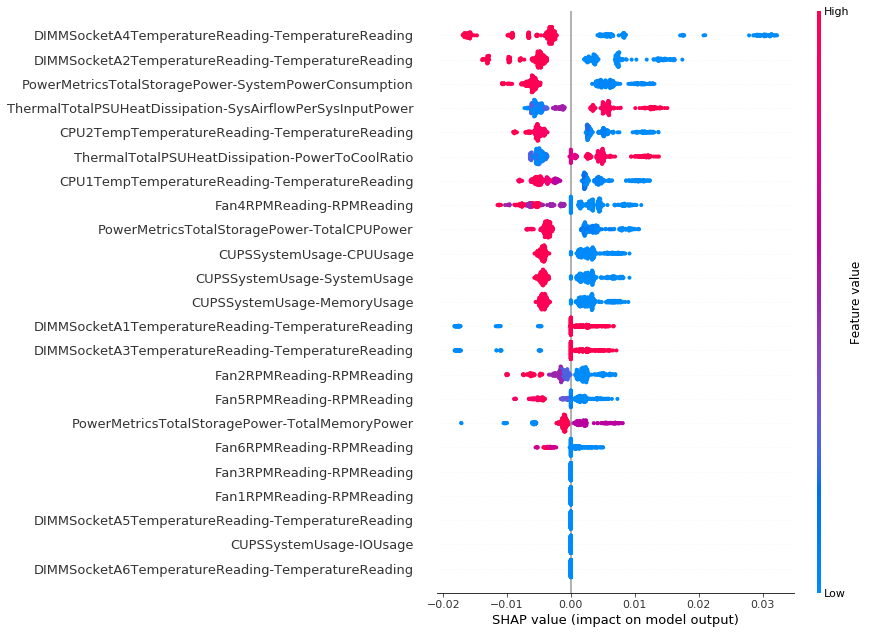



cluster 1


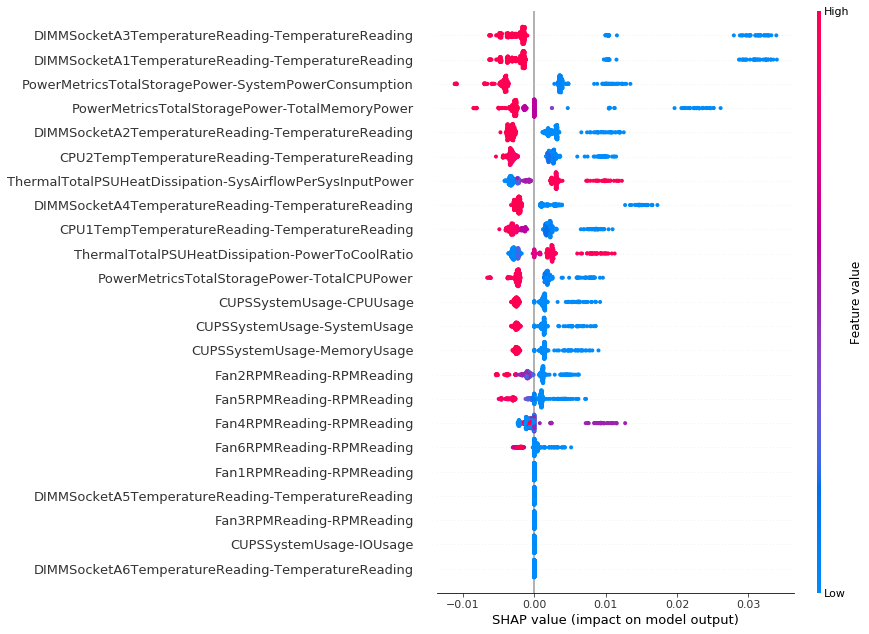



cluster 2


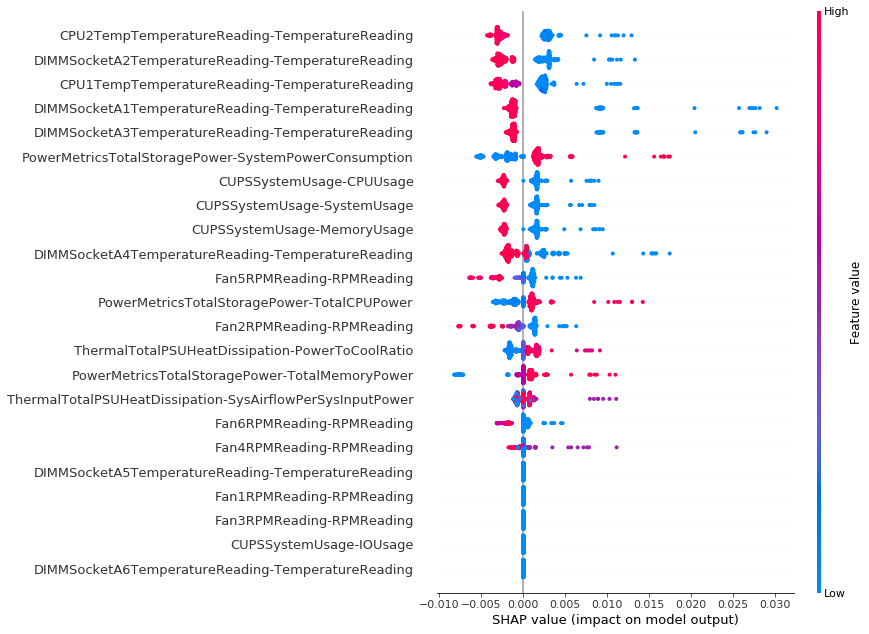



cluster 3


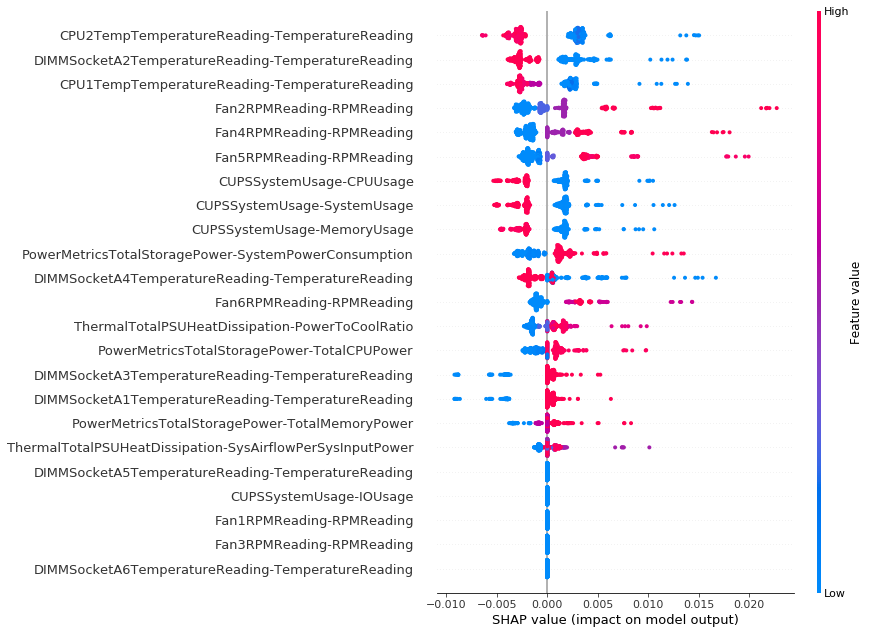



cluster 4


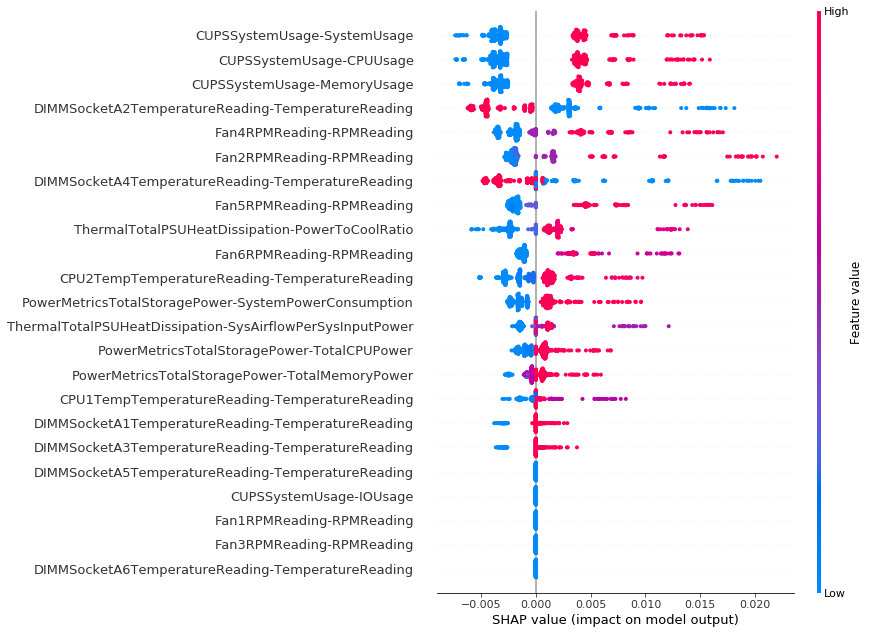



cluster 5


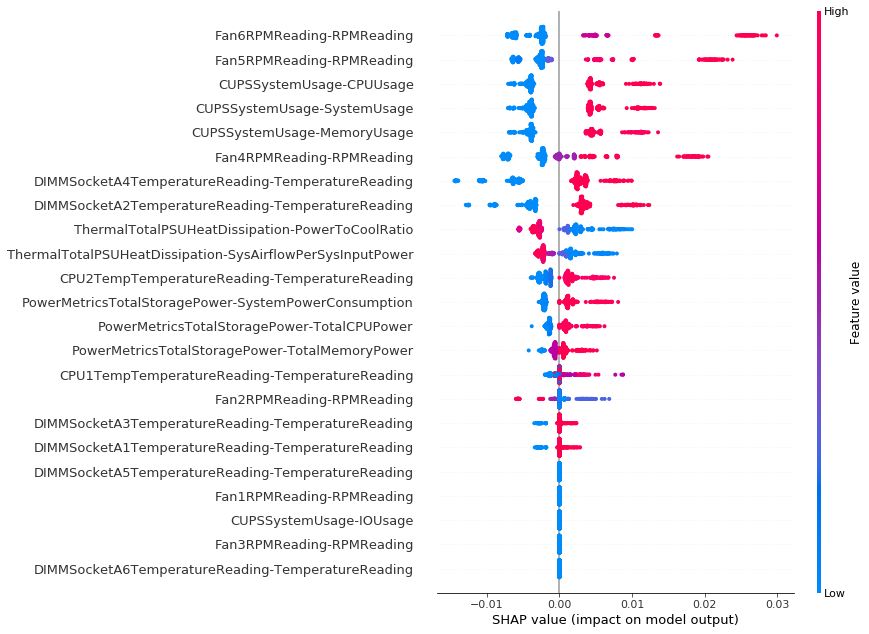



cluster 6


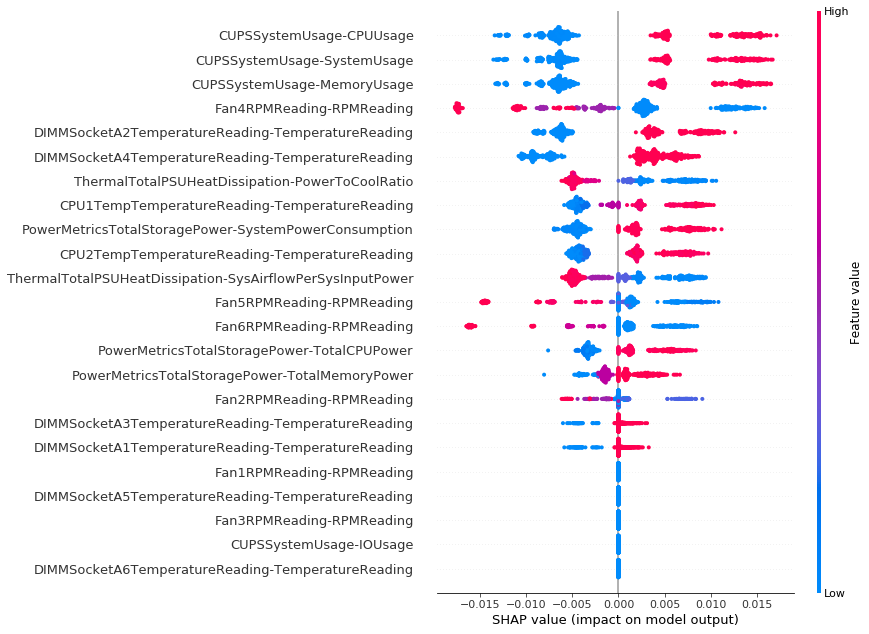



cluster 7


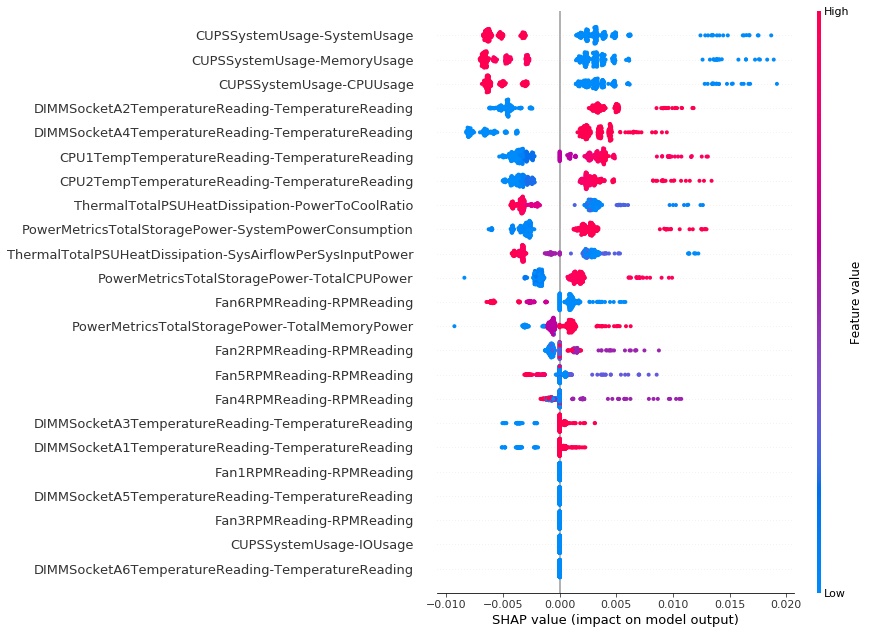



cluster 8


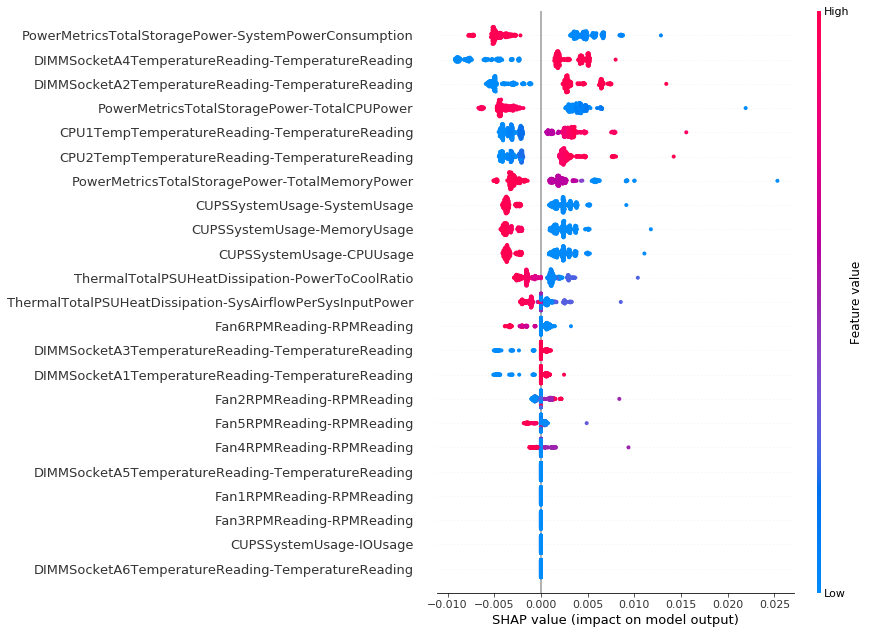

In [12]:
## Show feature importance for each instance/observation by class
for i in range(len_cluster):
    f = shap.summary_plot(shap_values[i], X_test, max_display = len(feature_cols), show=False, plot_type = "dot", feature_names=feature_cols)
    print("cluster", i)
    plt.show(f)
    print("\n")